# Input.csv contains 

- Age 

- Sex

- bmi value

- Care Home type (PN, PC, PS, U)

- Ethnicity (6 categories)

- MSOA

- STP

- IMD (rounded to nearest 100)

- rural/urban

- HighRisk Condition Flags (chronic_kidney_disease, chronic_liver_disease, current_copd, dementia, diabetes, haematological_cancer, permanant_immunosuppression, temporary_immunosuppression, solid_organ_transplantation, stroke)

## Packages

In [15]:
import pandas as pd
import numpy as np
import pyspark.sql
import matplotlib.pyplot as plt
import seaborn as sn

## Data

In [45]:
df = pd.read_csv("../output/input.csv")
df.iloc[:,5:15] = df.iloc[:,5:15].where(df.iloc[:,5:15].isnull(), 1).fillna(0).astype(int)
df.loc[:,'ethnicity'] = df.loc[:,'ethnicity'].fillna(-99)
df.loc[:,'bmi'] = df.loc[:,'bmi'].fillna(-99)
df.head()

,patient_id,age,sex,care_home_type,ethnicity,chronic_kidney_disease,chronic_liver_disease,current_copd,dementia,diabetes,haematological_cancer,permanant_immunosuppression,temporary_immunosuppression,solid_organ_transplantation,stroke,bmi,stp,msoa,imd,rural_urban
0,0,45,F,U,2.0,1,0,1,0,0,0,0,0,0,0,-99.000000,STP1,MSOA1,300,urban
1,1,82,M,PN,4.0,0,0,0,0,0,0,1,0,0,0,54.926454,STP1,MSOA1,300,urban
2,2,40,F,U,3.0,0,0,0,0,0,1,0,0,0,0,-99.000000,STP2,MSOA2,300,urban
3,3,40,M,U,-99.0,0,0,0,0,0,1,0,0,0,0,16.986886,STP2,MSOA1,200,urban
4,4,36,F,U,3.0,0,1,1,0,0,1,0,0,0,1,35.758961,STP1,MSOA1,300,urban


## Quick Summary stats

In [46]:
df.describe()

,patient_id,age,ethnicity,chronic_kidney_disease,chronic_liver_disease,current_copd,dementia,diabetes,haematological_cancer,permanant_immunosuppression,temporary_immunosuppression,solid_organ_transplantation,stroke,bmi,imd
count,10000.00000,10000.000000,10000.000000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.00000,10000.000000,10000.00000
mean,4999.50000,40.180200,-22.491700,0.20000,0.20000,0.20000,0.20000,0.20000,0.20000,0.20000,0.20000,0.20000,0.20000,-18.663599,260.77000
std,2886.89568,23.466563,44.191434,0.40002,0.40002,0.40002,0.40002,0.40002,0.40002,0.40002,0.40002,0.40002,0.40002,66.060435,65.69961
min,0.00000,0.000000,-99.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-99.000000,100.00000
25%,2499.75000,21.000000,-24.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-99.000000,200.00000
50%,4999.50000,40.000000,2.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,25.050358,300.00000
75%,7499.25000,58.000000,4.000000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,37.025094,300.00000
max,9999.00000,109.000000,5.000000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,78.218459,300.00000


## Feature Generation

Set High and Medium Risk Flags based on conditions.  

Set priority flag based on eligibility criteria

In [47]:
df['num_conditions'] = df.iloc[:,5:15].sum(axis=1)
df['risk'] = 0
conditions = [
    (df['num_conditions']==0),
    (df['num_conditions']>0) & (df['num_conditions']<3),
    (df['num_conditions']>=3)
]
values = ['low','medium','high']
df['risk'] = np.select(conditions, values)
df.head()

,patient_id,age,sex,care_home_type,ethnicity,chronic_kidney_disease,chronic_liver_disease,current_copd,dementia,diabetes,...,temporary_immunosuppression,solid_organ_transplantation,stroke,bmi,stp,msoa,imd,rural_urban,num_conditions,risk
0,0,45,F,U,2.0,1,0,1,0,0,...,0,0,0,-99.000000,STP1,MSOA1,300,urban,2,medium
1,1,82,M,PN,4.0,0,0,0,0,0,...,0,0,0,54.926454,STP1,MSOA1,300,urban,1,medium
2,2,40,F,U,3.0,0,0,0,0,0,...,0,0,0,-99.000000,STP2,MSOA2,300,urban,1,medium
3,3,40,M,U,-99.0,0,0,0,0,0,...,0,0,0,16.986886,STP2,MSOA1,200,urban,1,medium
4,4,36,F,U,3.0,0,1,1,0,0,...,0,0,1,35.758961,STP1,MSOA1,300,urban,4,high


In [51]:
df['priority'] = 0
conditions = [
    (df['age'] >= 65) & (df['care_home_type'] != 'U'),
    (df['age'] >= 80) & (df['care_home_type'] == 'U'),
    (df['age'] >= 75) & (df['care_home_type'] == 'U'),
    (df['age'] >= 70) & (df['care_home_type'] == 'U'),
    (df['age'] >= 65) & (df['care_home_type'] == 'U'),
    (df['age'] < 65) & (df['risk'] == 'high'),
    (df['age'] < 65) & (df['risk'] == 'medium'),
    (df['age'] >= 60) & (df['risk'] == 'low'),
    (df['age'] >= 55) & (df['risk'] == 'low'),
    (df['age'] >= 50) & (df['risk'] == 'low'),
    (df['age'] < 50)
]
values = [1,2,3,4,5,6,7,8,9,10,11]
df['priority'] = np.select(conditions, values)
df.head()

,patient_id,age,sex,care_home_type,ethnicity,chronic_kidney_disease,chronic_liver_disease,current_copd,dementia,diabetes,...,solid_organ_transplantation,stroke,bmi,stp,msoa,imd,rural_urban,num_conditions,risk,priority
0,0,45,F,U,2.0,1,0,1,0,0,...,0,0,-99.000000,STP1,MSOA1,300,urban,2,medium,7
1,1,82,M,PN,4.0,0,0,0,0,0,...,0,0,54.926454,STP1,MSOA1,300,urban,1,medium,1
2,2,40,F,U,3.0,0,0,0,0,0,...,0,0,-99.000000,STP2,MSOA2,300,urban,1,medium,7
3,3,40,M,U,-99.0,0,0,0,0,0,...,0,0,16.986886,STP2,MSOA1,200,urban,1,medium,7
4,4,36,F,U,3.0,0,1,1,0,0,...,0,1,35.758961,STP1,MSOA1,300,urban,4,high,6


In [52]:
freq = df['priority'].value_counts().sort_index()
display(freq)

1      250
2      424
3      266
4      399
5      437
6     2646
7     4662
8       59
9       73
10      83
11     701
Name: priority, dtype: int64

## Waterfall chart

In [53]:
csum=freq.cumsum().shift(1).fillna(0)
#step = csum.reset_index(drop=True).repeat(3).shift(1)
#step[1::3] = np.nan
display(csum)
#display(step)

1        0.0
2      250.0
3      674.0
4      940.0
5     1339.0
6     1776.0
7     4422.0
8     9084.0
9     9143.0
10    9216.0
11    9299.0
Name: priority, dtype: float64

[Text(0, 0, 'Older Residents & care workers in Care Homes'),
 Text(1, 0, '80+ & Health and care Workers'),
 Text(2, 0, '75+'),
 Text(3, 0, '70+'),
 Text(4, 0, '65+'),
 Text(5, 0, 'High Risk under 65'),
 Text(6, 0, 'Medium Risk under 65'),
 Text(7, 0, '60+'),
 Text(8, 0, '55+'),
 Text(9, 0, '50+'),
 Text(10, 0, 'Rest')]

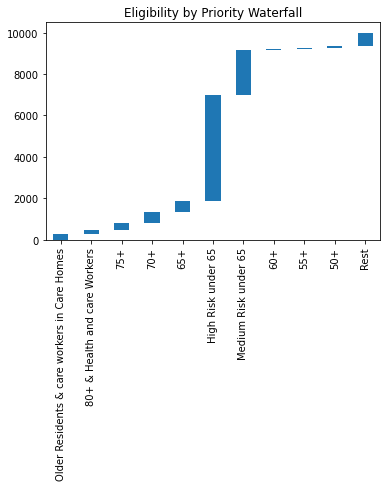

In [238]:
labels = ['Older Residents & care workers in Care Homes', '80+ & Health and care Workers', '75+', '70+', '65+', 'High Risk under 65', 'Medium Risk under 65', '60+', '55+', '50+', 'Rest']
my_plot = freq.plot(kind='bar', stacked=True, bottom=csum,legend=None, title="Eligibility by Priority Waterfall")
my_plot.set_xticklabels(labels)
#my_plot.plot(step.index, step.values,'k')

# Ethnicity, IMD, Rurality

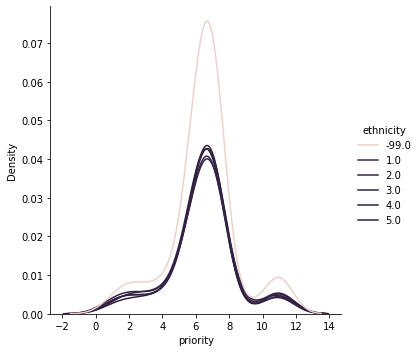

In [54]:
sn.displot(df, x="priority", hue="ethnicity", kind="kde", bw_adjust=2)

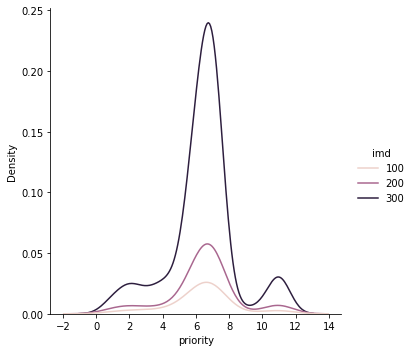

In [56]:
sn.displot(df, x="priority", hue="imd", kind="kde", bw_adjust=2)

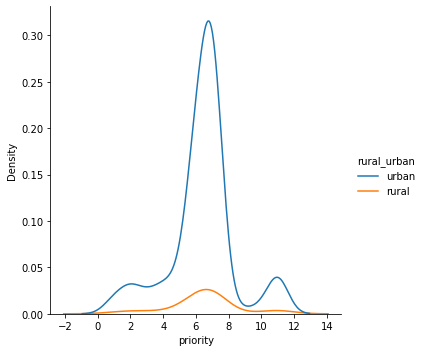

In [57]:
sn.displot(df, x="priority", hue="rural_urban", kind="kde", bw_adjust=2)

# STP, MSOA

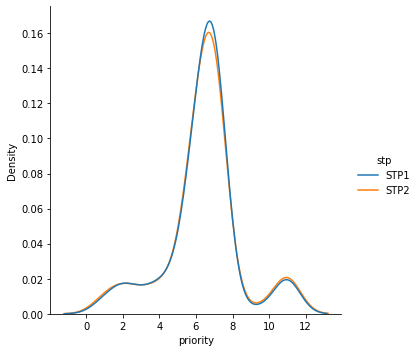

In [59]:
sn.displot(df, x="priority", hue="stp", kind="kde", bw_adjust=2)

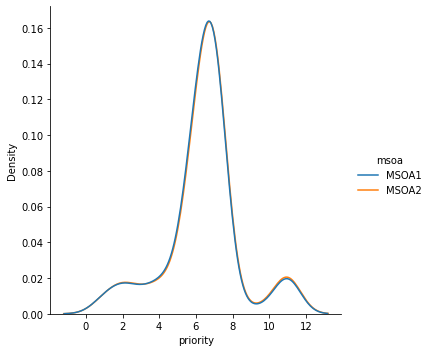

In [58]:
sn.displot(df, x="priority", hue="msoa", kind="kde", bw_adjust=2)